In [1]:
import numpy as np
import zarr
from matplotlib import pyplot as plt
import cv2


import torch
import torch.nn as nn
import torchvision

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

from models import pusht_networks
from datasets import pusht_dataset
import toucht_train as tt

/home/tom/miniconda3/envs/roboarm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### Dataset Parameters
dataset_path = "data/toucht.zarr.zip"
weight_path = "savedWeights/toucht_trial.ckpt"
pred_horizon = 12
obs_horizon = 2
action_horizon = 6
num_img_inputs = 2
raw_img_width = 512
raw_img_height = 512

#### Agent Paramters
agent_state_dim = 4
action_dim = 4
net_img_input_width = 96
net_img_input_height = 96

#### Image Network Paramters
vision_feature_dim = 512
obs_dim = 2*vision_feature_dim + agent_state_dim

#### Diffusion Parameters
diffusion_steps = 100
beta_schedule = 'squaredcos_cap_v2'
clip_sample = True
prediction_type = 'epsilon'

In [3]:
device = torch.device('cuda')

In [4]:
# Create network
vision_encoder_1 = tt.get_resnet('resnet18')
vision_encoder_2 = tt.get_resnet('resnet18')
# replace all BatchNorm with GroupNorm to work with EMA
# performance will tank if you forget to do this!
vision_encoder_1 = pusht_networks.replace_bn_with_gn(vision_encoder_1)
vision_encoder_2 = pusht_networks.replace_bn_with_gn(vision_encoder_2)

noise_pred_net = pusht_networks.ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

nets = nn.ModuleDict({
    'vision_encoder_1' : vision_encoder_1,
    'vision_encoder_2' : vision_encoder_2,
    'noise_pred_net' : noise_pred_net
})

# Load to gpu
_ = nets.to(device)

# Load weights
state_dict = torch.load(weight_path, map_location='cuda')
nets.load_state_dict(state_dict)

number of parameters: 9.468826e+07


/tmp/ipykernel_2162394/2838722136.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weight_path, map_location='cuda')


<All keys matched successfully>

In [5]:
dataloader, stats = tt.setup_data()

In [6]:
noise_scheduler = DDPMScheduler(
    num_train_timesteps = diffusion_steps,
    beta_schedule = beta_schedule,
    clip_sample = clip_sample,
    prediction_type = prediction_type
)

In [7]:
train_data = zarr.open("data/toucht.zarr.zip", 'r')
dataset_size = len(train_data["meta/episode_ends"])
print(train_data.tree())

/
 ├── data
 │   ├── action (704, 4) float32
 │   ├── img1 (704, 512, 512, 3) float32
 │   ├── img2 (704, 512, 512, 3) float32
 │   └── state (704, 4) float32
 └── meta
     ├── episode_ends (40,) int64
     ├── master_time (704,) float64
     └── slave_time (704,) float64


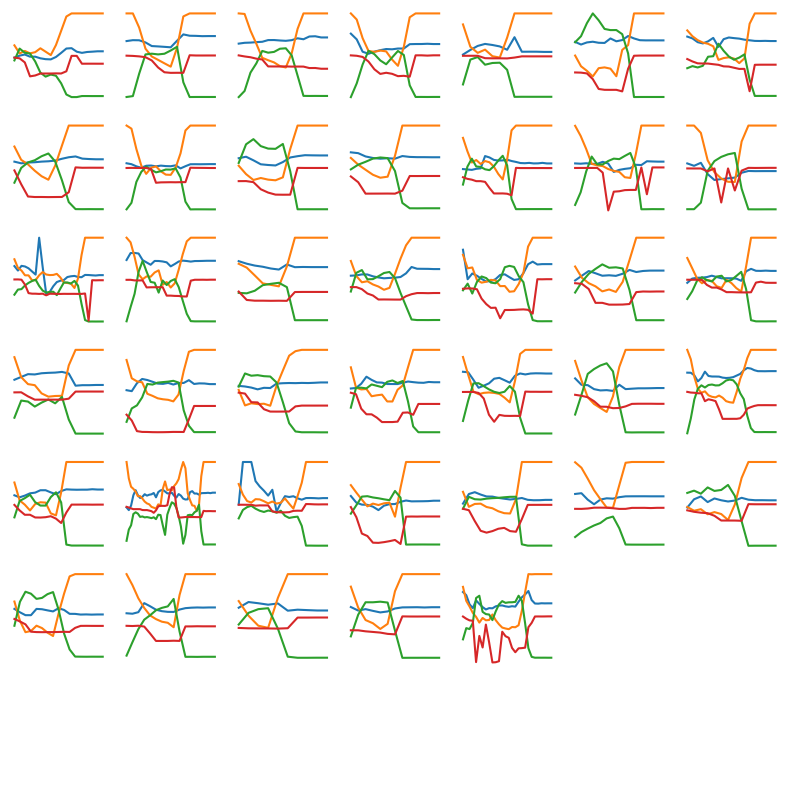

In [18]:
plot_dim = int(np.ceil(np.sqrt(dataset_size)))
fig, axs = plt.subplots(ncols=plot_dim,nrows=plot_dim, figsize=(8,8), sharey=True)

start = 0
end = 0
for n, ax in enumerate(axs):
    for m, a in enumerate(ax):
        if n*plot_dim + m < dataset_size:
            start = end
            episode_idx = n*plot_dim + m
            end = train_data["meta/episode_ends"][episode_idx]
            a.plot(train_data["data"]["action"][start:end])
        a.axis('off')

plt.tight_layout()
plt.show()

In [9]:
indices = pusht_dataset.create_sample_indices(
            episode_ends=train_data["meta/episode_ends"],
            sequence_length=pred_horizon,
            pad_before=obs_horizon-1,
            pad_after=action_horizon-1)

In [10]:
train_dataset = pusht_dataset.PushTImageDataset(
    dataset_path,
    pred_horizon,
    obs_horizon,
    action_horizon
)

In [12]:
ml_actions = []

start = 0
end = 0
for idx in range(dataset_size):
    print(f'Training sample: {idx}')
    start = end
    end = train_data["meta/episode_ends"][idx]
    vid1 = torch.from_numpy(
        train_dataset.normalized_train_data['image_1'][start:end]
    ).to(device, dtype=torch.float32)
    vid2 = torch.from_numpy(
        train_dataset.normalized_train_data['image_2'][start:end]
    ).to(device, dtype=torch.float32)
    states = torch.from_numpy(
        train_dataset.normalized_train_data['agent_pos'][start:end]
    ).to(device, dtype=torch.float32)

    actions_sequence = []
    for n in range(2, end-start):
        # encoder vision features
        # infer action
        with torch.no_grad():
            image_features_1 = nets['vision_encoder_1'](vid1[n-2:n])
            image_features_2 = nets['vision_encoder_2'](vid2[n-2:n])

            # concat with low-dim observations
            obs_features = torch.cat([image_features_1, image_features_2,  states[n-2:n]], dim=-1)
            # reshape observation to (B,obs_horizon*obs_dim)
            obs_cond = obs_features.unsqueeze(0).flatten(start_dim=1)

            # initialize action from Guassian noise
            noisy_action = torch.randn((1, pred_horizon, action_dim), device=device)
            naction = noisy_action

            # init scheduler
            noise_scheduler.set_timesteps(diffusion_steps)

            for k in noise_scheduler.timesteps:
                # predict noise
                noise_pred = nets['noise_pred_net'](
                    sample=naction,
                    timestep=k,
                    global_cond=obs_cond
                )

                # inverse diffusion step (remove noise)
                naction = noise_scheduler.step(
                    model_output=noise_pred,
                    timestep=k,
                    sample=naction
                ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = pusht_dataset.unnormalize_data(naction, stats=stats['action'])
        actions_sequence += [action_pred]
    ml_actions += [actions_sequence]

Training sample: 0


Training sample: 1
Training sample: 2
Training sample: 3
Training sample: 4
Training sample: 5
Training sample: 6
Training sample: 7
Training sample: 8
Training sample: 9
Training sample: 10
Training sample: 11
Training sample: 12
Training sample: 13
Training sample: 14
Training sample: 15
Training sample: 16
Training sample: 17
Training sample: 18
Training sample: 19
Training sample: 20
Training sample: 21
Training sample: 22
Training sample: 23
Training sample: 24
Training sample: 25
Training sample: 26
Training sample: 27
Training sample: 28
Training sample: 29
Training sample: 30
Training sample: 31
Training sample: 32
Training sample: 33
Training sample: 34
Training sample: 35
Training sample: 36
Training sample: 37
Training sample: 38
Training sample: 39


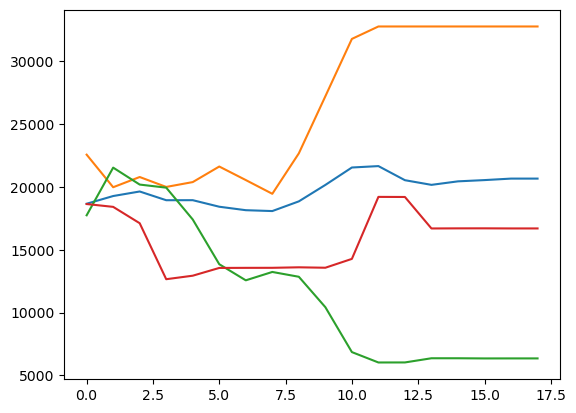

In [21]:
start = 0
episode_idx = 0
end = train_data["meta/episode_ends"][episode_idx]
plt.plot(train_data["data"]["action"][start:end])
plt.show()

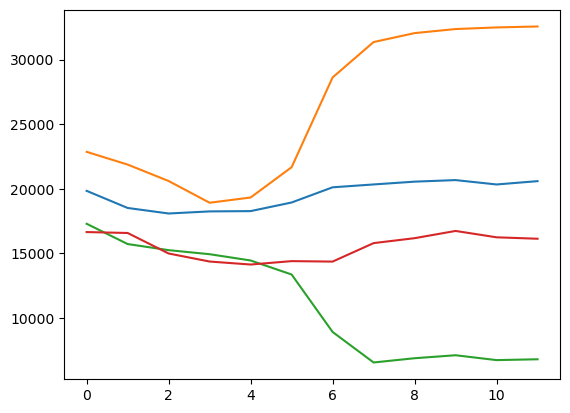

In [30]:
plt.plot(ml_actions[0][0])
plt.show()

In [15]:
ml_actions[0][0]

array([[19842.533 , 22861.36  , 17293.145 , 16651.244 ],
       [18517.266 , 21877.387 , 15724.185 , 16580.121 ],
       [18089.176 , 20604.371 , 15250.639 , 14992.562 ],
       [18251.307 , 18921.715 , 14936.992 , 14369.472 ],
       [18274.043 , 19327.492 , 14451.518 , 14137.645 ],
       [18940.92  , 21671.855 , 13366.158 , 14401.107 ],
       [20116.92  , 28622.93  ,  8917.187 , 14364.998 ],
       [20338.406 , 31364.3   ,  6553.205 , 15795.107 ],
       [20555.346 , 32057.043 ,  6882.6924, 16178.092 ],
       [20675.875 , 32371.582 ,  7113.5317, 16737.766 ],
       [20336.914 , 32496.652 ,  6736.3325, 16245.266 ],
       [20594.395 , 32570.459 ,  6801.5474, 16134.766 ]], dtype=float32)